In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from sparsesvd import sparsesvd 
from scipy.sparse import csc_matrix
import seaborn as sns; sns.set()

In [3]:
data = pd.read_csv('data/data.txt', sep=' ', header = None)
X = np.array(data.T)

In [4]:
def SSVD_primary(X, gamma1 = 2, gamma2 = 2, tol = 1e-4, max_iter = 100):
    """SSVD for 1 layer"""
    u, s, v = sparsesvd(csc_matrix(X), k=1)
    
    # initializations
    n = X.shape[0]
    d = X.shape[1]
    u = u.reshape((n,1))
    v = v.reshape((d,1))
    u_delta = 1
    v_delta = 1
    niter = 0
    SST = np.sum(X**2)
    
    while((u_delta > tol) or (v_delta > tol)):
        niter += 1

        # update v
        Xu = X.T @ u
        w2_inv = np.abs(Xu)**gamma2
        sigma_sq = np.abs(SST - sum(Xu**2))/(n*d-d)   #np.trace((X-s*u@v.T) @ (X-s*u@v.T).T)/(n*d-d)

        lambda2s = np.unique(np.append(np.abs(Xu*w2_inv), 0))
        lambda2s.sort()                                   # possible lambda2/2

        # best BIC
        BICs = np.ones(lambda2s.shape[0]-1)*np.Inf
        for i in range(BICs.shape[0]):
            v_temp = np.sign(Xu)*(np.abs(Xu) >= lambda2s[i] / w2_inv)*(np.abs(Xu) - lambda2s[i] / w2_inv)
            BICs[i] = np.sum((X-u@v_temp.T)**2)/sigma_sq/(n*d) + np.sum(v_temp!=0)*np.log(n*d)/(n*d)
        best = np.argmin(BICs)

        lambda2 = lambda2s[best]
        v_new = np.sign(Xu)*(np.abs(Xu) >= lambda2 / w2_inv)*(np.abs(Xu) - lambda2 / w2_inv)
        v_new = v_new/np.sqrt(np.sum(v_new**2))

        v_delta = np.sqrt(np.sum((v-v_new)**2))
        v = v_new


        # update u
        Xv = X @ v
        w1_inv = np.abs(Xv)**gamma1
        sigma_sq = np.abs(SST - sum(Xv**2))/(n*d-n) 

        lambda1s = np.unique(np.append(np.abs(Xv*w1_inv), 0))
        lambda1s.sort()                                   # possible lambda1/2

        # best BIC
        BICs = np.ones(lambda1s.shape[0]-1)*np.Inf
        for i in range(BICs.shape[0]):
            u_temp = np.sign(Xv)*(np.abs(Xv) >= lambda1s[i] / w1_inv)*(np.abs(Xv) - lambda1s[i] / w1_inv)
            BICs[i] = np.sum((X-u_temp@v.T)**2)/sigma_sq/(n*d) + np.sum(u_temp!=0)*np.log(n*d)/(n*d)
        best = np.argmin(BICs)

        lambda1 = lambda1s[best]
        u_new = np.sign(Xv)*(np.abs(Xv) >= lambda1 / w1_inv)*(np.abs(Xv) - lambda1 / w1_inv)
        u_new = u_new/np.sqrt(np.sum(u_new**2))

        u_delta = np.sqrt(np.sum((u-u_new)**2))
        u = u_new

        # check iterations
        if niter > max_iter:
            print("Fail to converge! Increase the max_iter!")
            break
    return(np.ravel(u), s, np.ravel(v), niter)

In [5]:
%%time
u, s, v, niter = SSVD_primary(X, gamma1 = 2, gamma2 = 2, tol = 1e-4, max_iter = 100)

CPU times: user 8min 20s, sys: 14min 45s, total: 23min 6s
Wall time: 2min 56s


In [6]:
n = X.shape[0]
d = X.shape[1]
first = s*u.reshape((n, 1))@v.reshape((1, d))

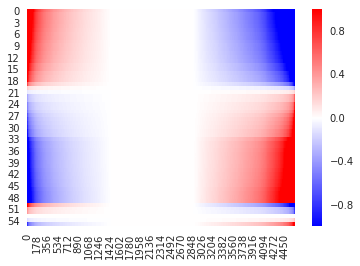

In [7]:
group1 = range(20)
group2 = range(20, 33)
group3 = range(33, 50)
group4 = range(50, 56)

row_idx = np.concatenate((np.argsort(u[group1]), np.argsort(u[group2])+20, np.argsort(u[group3])+33, np.argsort(u[group4])+50))
col_nonzero = np.argsort(np.abs(v))[8000:]
v_nonzero = v[col_nonzero]
first_nonzero = first[:,col_nonzero]
col_idx = np.argsort(v_nonzero)

ax = sns.heatmap(first_nonzero[np.ix_(row_idx, col_idx)], vmin=-1, vmax=1, cmap = 'bwr')